In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, StructureCursor, IDC
from CompoTree import OrthoNode

In [4]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()

In [5]:
hit_x = ctree.find("女", bmp_only=True)[2]
hit_x

('姦', [⿱0姦])

In [6]:
ctree.select(hit_x[0], hit_x[1])

'女'

In [7]:
yo_hits = ctree.find("又", max_depth=1, bmp_only=True)

In [8]:
yo_hits_simp = [x for x in yo_hits if tsvars.is_simplified(x[0])]

In [9]:
yo_trad_items = []
flag_map = {"難": "J", "艱": "J", "漢": "J", "嘆": "J"}
for hit_x in yo_hits_simp:
    trad_char = tsvars.convert(hit_x[0])[0]
    if hit_x[0] == "鸡":
        trad_char = "鷄"
    try:
        hit_x[1][0].flag = flag_map.get(trad_char, "")     
        trad_compo = ctree.select(trad_char, hit_x[1], use_flag="all")
        yo_trad_items.append((trad_char, hit_x[0], trad_compo))
    except IndexError as ex:
        print(str(ex), trad_char, hit_x[1])
yo_trad_items

IDC does not match 雙 [⿰0双]


[('聖', '圣', '𦔻'),
 ('勸', '劝', '雚'),
 ('難', '难', '𦰩'),
 ('艱', '艰', '𦰩'),
 ('對', '对', <⿱:业𦍌>),
 ('鷄', '鸡', '奚'),
 ('變', '变', '攵'),
 ('鳳', '凤', '𩾏'),
 ('歡', '欢', '雚'),
 ('漢', '汉', '𦰩'),
 ('僅', '仅', '堇'),
 ('敘', '叙', '攵'),
 ('戲', '戏', '䖒'),
 ('嘆', '叹', '𦰩'),
 ('馭', '驭', '又'),
 ('鄧', '邓', '登'),
 ('觀', '观', '雚'),
 ('權', '权', '雚')]

In [34]:
set([x[2] for x in yo_trad_items])

{<⿱:业𦍌>, '䖒', '又', '堇', '奚', '攵', '登', '雚', '𦔻', '𦰩', '𩾏'}

In [14]:
from graphviz import Graph

In [35]:
import pickle
with open("../data/asbc5_characters.pkl", "rb") as fin:
    aschfreq = pickle.load(fin)

In [44]:
sum(aschfreq.values()) * 1e-5

155.29115000000002

In [52]:
import re
char_list = [x for x in aschfreq.keys() if re.match("[一-龜]", x)]
sorted_chars = sorted(char_list, key=aschfreq.get, reverse=True)
char_list = sorted_chars[:5000]

In [57]:
from collections import defaultdict
flag_map = {"難": "J", "艱": "J", "漢": "J", "嘆": "J"}
nodes = defaultdict(set)
edges = set()
for item_x in yo_trad_items:
    trad_char = item_x[0]
    simp_char = item_x[1]
    nodes["trad"].add(trad_char)
    nodes["simp"].add(simp_char)
    # edges.add((trad_char, simp_char))
    trad_ortho = ctree.query(trad_char, 
                              max_depth=1, 
                              use_flag=flag_map.get(trad_char, ""))[0]
    simp_ortho = ctree.query(simp_char,
                              max_depth=1,
                              use_flag=flag_map.get(simp_char, ""))[0]
    for compo_i in [0, 1]:
        if trad_ortho.idc != simp_ortho.idc:
            continue
        trad_compo = trad_ortho.get_component(compo_i)
        simp_compo = simp_ortho.get_component(compo_i)        
        nodes["compo"].add(str(trad_compo))
        nodes["compo"].add(str(simp_compo))
        edges.add((trad_char, str(trad_compo)))
        edges.add((simp_char, str(simp_compo)))
        if simp_compo == "又" and simp_compo != trad_compo:         
            edges.add((str(trad_compo), str(simp_compo)))
            
            trad_neighs = [x[0] for x in 
                           ctree.find(trad_compo, max_depth=1, 
                                      use_flag=flag_map.get(simp_char, ""),
                                      bmp_only=True)]
            trad_neighs = [x for x in trad_neighs if x in char_list]
            neighs = set(trad_neighs).difference([x[0] for x in yo_trad_items])            
            simp_neighs = [tsvars.convert(x)[0] for x in neighs]
            nodes["trad_neighs"] |= neighs
            nodes["simp_neighs"] |= set(simp_neighs)
            # edges |= set(((trad_char, neigh_x) for neigh_x in neighs))
            edges |= set(((neigh_x, trad_compo) for neigh_x in neighs))
            edges |= set(((neigh_t, neigh_s) for neigh_t, neigh_s in zip(neighs, simp_neighs)))
        
# ctree.query(yo_trad_items[0][0], max_depth=1)[0].leaf_components()

In [58]:
sum(len(x) for x in nodes.values())

186

In [59]:
G = Graph(comment="Component Graph", format="svg", engine='dot')
G.attr(rankdir="TB")
G.attr('node', fontname="HanaMinA")
for group in ("trad", "trad_neighs", "compo", "simp"):
    sG = Graph(name="trad_chars")
    # sG.attr(rank="same")
    for n in nodes[group]:
        sG.node(n, n)
    G.subgraph(sG)
    
G.edges(edges)

In [60]:
# print(G.source)

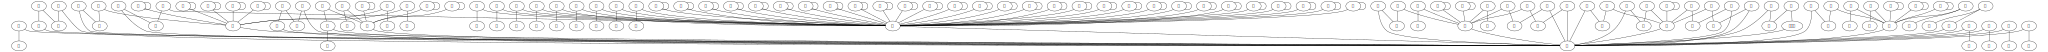

In [61]:
G

In [137]:
trad_ortho.get_component(0, use_flag="all")

['氵']